## CNN을 활용한 이미지 자동채색
- 흑백 이미지를 컬러 이미지로 바꾸는 것
- low 레벨 특징 추출기: 이미지의 국소적 특징 추출
    - 이미지 크기 점차적으로 감소
- middle 레벨 특징 추출기: 중간 크기의 특징 추출
    - 이미지 크기 변화 없음
- global 레벨 특징 추출기: 이미지의 전체적인 특징 추출
    - 이미지 크기 점차적으로 감소, 평탄화 -> 선형계층
- 채색: 업샘플링 계층

In [2]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from model.autoColoring import AutoColoringModel
from utils.autoColoring import AutoColoring, rgb2lab, lab2rgb

c:\Users\seung\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### utils

In [ ]:
import cv2
import numpy as np
import glob
from PIL import Image

from torch.utils.data.dataset import Dataset

def rgb2lab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

def lab2rgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

class AutoColoring(Dataset):
  def __init__(self):
    self.data = glob.glob("./data/color_data/100/*.jpg")

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    rgb = np.array(Image.open(self.data[i]).resize((256, 256)))
    lab = rgb2lab(rgb)
    lab = lab.transpose((2, 0, 1)).astype(np.float32)
    return lab[0], lab[1:]

#### 학습

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoColoringModel().to(device)
dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(params=model.parameters(), lr=0.01)

for epoch in range(1):
  iterator = tqdm.tqdm(loader)
  for L, AB in iterator:
    L = torch.unsqueeze(L, dim=1).to(device)
    optim.zero_grad()
    pred = model(L)
    loss = nn.MSELoss()(pred, AB.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./data/weights/AutoColor.pth")

epoch:0 loss:17216.041015625: 100%|██████████| 4/4 [00:23<00:00,  5.98s/it]


#### 평가

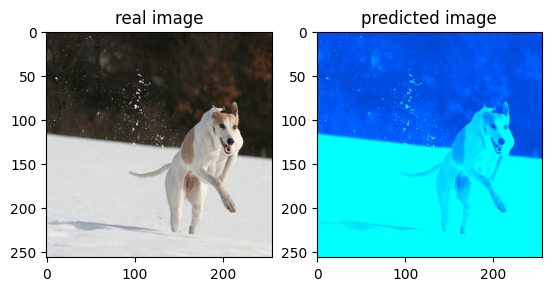

In [4]:
test_L, test_AB = dataset[0]
test_L = np.expand_dims(test_L, axis=0)
real_img = np.concatenate([test_L, test_AB])
real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
real_img = lab2rgb(real_img)

with torch.no_grad():
  model.load_state_dict(torch.load("./data/weights/AutoColor.pth", map_location=device))

  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
  pred_AB = model(input_tensor)

  pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.title("real image")
plt.subplot(1, 2, 2)
plt.imshow(pred_LAB)
plt.title("predicted image")
plt.show()